# Symbol resolving

EDA notebook to inspect the images to be fed to the model.
And to find out how I can make openCV's findcontours combine contours of individual traces that should be read as a single symbol

Notebook by Martijn de Vries <br>
martijndevries91@gmail.com

In [529]:
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as patches

## Class distribution

First of all, how images of individual symbols do we have?

In [731]:
label_dirs = glob.glob('../img_data/train_symbols/*')

What symbols are on the images, and how many in each class?

In [3]:
label_dic = {}
for label_dir in label_dirs:
    label = label_dir.split('label_')[-1]
    label_imgs = glob.glob(label_dir + '/*png')
    label_dic[label] = len(label_imgs)

In [4]:
len(label_dic)

100

What is their distribution?

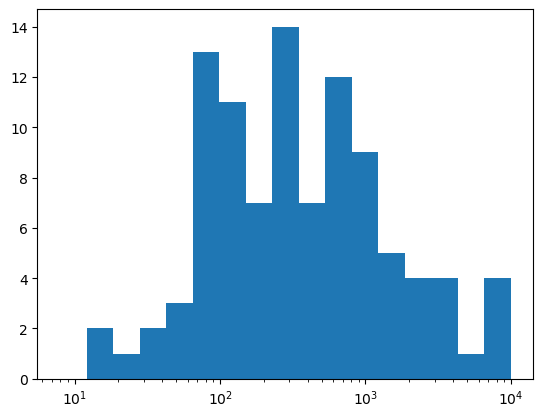

In [5]:
logbins = np.logspace(0.9, 4, 18)

plt.hist(label_dic.values(), bins=logbins)
plt.xscale('log')
plt.show()

And the cumulative distribution

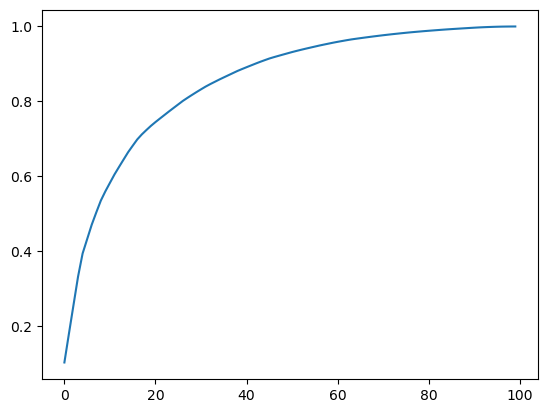

In [6]:
s_v = sorted(label_dic.values())[::-1]
s_cumu = np.cumsum(s_v)/sum(label_dic.values())

plt.plot(s_cumu)
plt.show()

I want to see how well openCV findcontours can actually read single symbols. One of the most obvious issues would be the 'equals', and 'greater or equal /lesser or equal than' signs. Those will always be read as two individual contours, given that they are separated from each other by some distance

In [8]:
eq_labels = ['=',  '\leq', '\geq']
eq_imgs = []
for label in eq_labels:
    eq_imgs += glob.glob('../img_data/train_symbols/label_' + label + '/*')

Plot how much these boxes typically overlap for equal signs

In [9]:
def calc_box_overlap(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)

    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

    r_l = [[],[]]
    for i,c in enumerate(cnt[1:3]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        r_l[1].append(x2+x1)
        r_l[0].append(x1)
    
    
    totl = max(r_l[1]) - min(r_l[0]) 
    overlap = min(r_l[1]) - max(r_l[0])
    try:
        return overlap/totl
    except:
        return 0

In [10]:
ol = []
for img_file in eq_imgs:
    ol.append(calc_box_overlap(img_file))

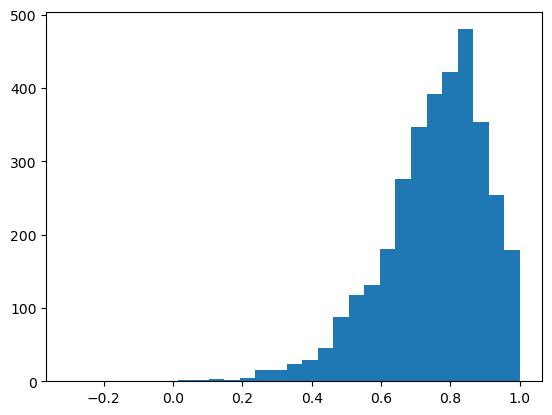

In [11]:
linbins = np.linspace(-0.3, 1, 30)
plt.hist(ol, bins=linbins);

In [12]:
ol_arr = np.array(ol)
bo = np.where(ol_arr < 0.25)[0]
print(f'Fraction of equal signs with less than 25% overlap: {len(bo)/len(ol)}')

Fraction of equal signs with less than 25% overlap: 0.004759071980963712


Based on this, I  might be able to make some inferences about when two boxes are likely to belong together or not

32 17 65 95
37 65 85 70


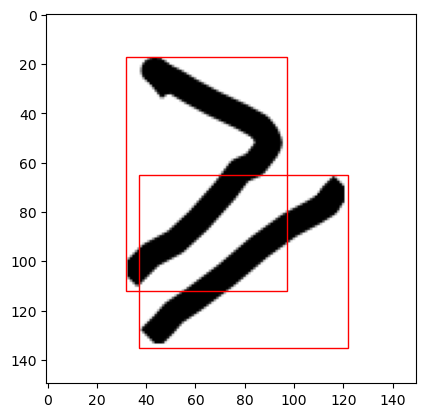

In [13]:
img = cv2.imread(eq_imgs[-1],cv2.IMREAD_GRAYSCALE)

ret,thresh=cv2.threshold(img, 230,255,cv2.THRESH_BINARY)
ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

fig, ax = plt.subplots()
ax.imshow(img, cmap='gray')

r_l = [[],[]]
for i,c in enumerate(cnt[1:]):
    x1,y1,x2,y2= cv2.boundingRect(c)
    print(x1,y1, x2, y2)

    rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    

## Resolving Symbols

How well can findContours do in general?

In [732]:
full_eq_imgs = glob.glob('../img_data/full_equations/*png')

In [305]:
def resolve_symbols_on_img_test(img_file):
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    ret,thresh=cv2.threshold(img,230,255,cv2.THRESH_BINARY)
    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])
    
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')

    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    return

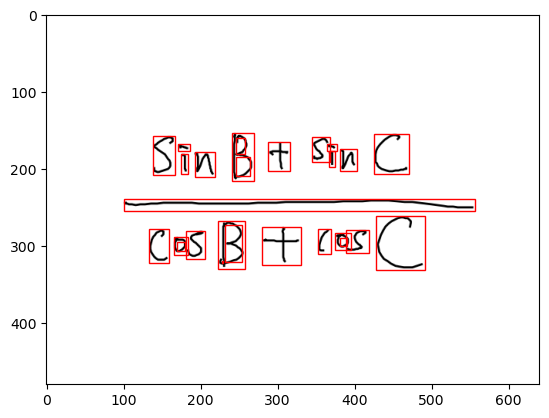

In [306]:
resolve_symbols_on_img_test(full_eq_imgs[36])

### Threshholding

The images that I am training the model on have all been created digitally with matplotlib. However, if I want to create a tool that can have real images uploaded as well, I'll need to think about how real-world pictures of handwritten equation will look, as well.

One issue is that lots of smaller features will show up (lines on the paper, or shadows, etc).  It seems that a combination of adaptive gaussian thresholding, then blurring, and then another binary tresholding works best to remove these smaller features.

Additionally, I will add a minimum bounding box size for a feature to be included in the box list. This value is somewhat heuristic, but seems to work well for my 3 sample images.

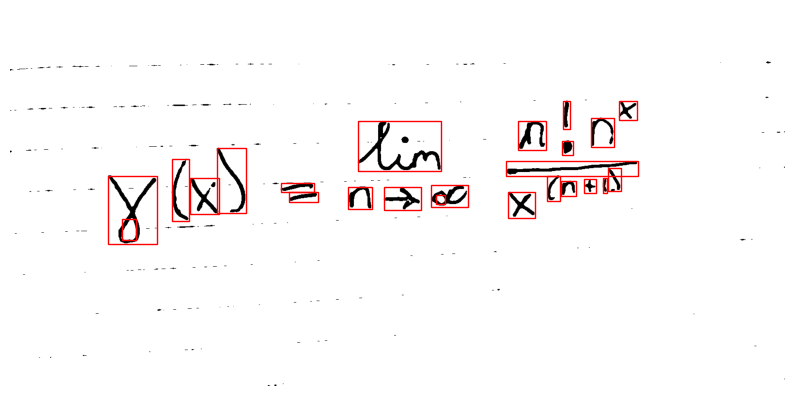

In [784]:
img_file = '../img_data/handwritten/math_martijn.jpeg'
#img_file = '../img_data/handwritten/math_martijn2.jpeg'
#img_file = '../img_data/handwritten/math_martijn3.jpeg'

img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
#ret,thresh=cv2.threshold(img,120, 255, cv2.THRESH_BINARY)
thresh  = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
blur = cv2.GaussianBlur(thresh,(13,13),0)
#bt = np.percentile(blur, 1.)
bt = 140
ret,thresh=cv2.threshold(blur,bt, 255, cv2.THRESH_BINARY)


ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])

fig, ax = plt.subplots(figsize=(10,8))
ax.imshow(thresh, cmap='gray')

size_list = []
boxes = 0
size_img = img.shape[0] * img.shape[1]

for i,c in enumerate(cnt[1:]):
    x1,y1,x2,y2= cv2.boundingRect(c)
    size = x2*y2
    size_list.append(size)
    if size > 2.2e-4 * size_img:
        boxes +=1
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

ax.set_frame_on(False)
ax.tick_params(axis='both',which='both',bottom=False, left=False, labelbottom=False, labelleft=False) 
    
fig.savefig('../figures/contours_example.png')
plt.show()

### Resolving symbols pipeline

There are some issues with this that I'll need to figure out: one obvious problem is that the two halves of the equals signs are read as two individual symbols. 

Because I'm going to be comparing a lot of boxes, I wrote a 'BoxPositions' class, which takes the coordinates of two boxes as input, and makes some comparitive operations (like checking for overlap in x or y coordinates) a little easier. To keep this notebook more readable, I've put the class in box_positions.py and simply import it here.

In [307]:
from box_positions import BoxPositions

Below, I'll give an overview of the steps taken by the preprocessing pipeline. The actual code can be found in resolve_symbols.py

### 1) Removing inner contours

findContours() sometimes also retrieves inner contours within symbols. For this reason, we calculate the area of each contour using the contourarea function(), setting orientation=True. Inner contours are always oriented clockwise, while outer contours are always oriented counterclockwise (see also <a href=https://stackoverflow.com/questions/45323590/do-contours-returned-by-cvfindcontours-have-a-consistent-orientation> here </a>). Therefore, contours with negative areas can be safely disregarded.

### 2) Finding out which boxes need to be merged

There are several mathematical symbols, like the equals sign or plus minus sign, that will show up as two separate contours. I want to merge these in the pipeline so that they can be read as a single symbol.

This function
1) Loops over the list of boxes
2) Compares each box with each other box
3) Finds which boxes have more than 25% overlap in x-coordinates with that box
4) Loop over each box with  overlapping boxes, and, out of the list of overlapping boxes, find the closest boxes above and below that box
5) If the closest boxes match some very specific criteria re: box lengths and distance, merge them by taking the min/max x/y coordinates of the two boxes as a new box
6) Remove the smaller boxes that were merged into one
7) Return the box list and the merged box list

LIMITATIONS: This step is difficult to get right. Being too lenient with the merging criteria means that a division bar might get merged to the symbols above/below it, while being too strict means that many '=' or plus-minus signs will not be merged. It's really difficult to know a priori if we're looking at eg two parts of an equals sign or exclamation mark, or a fraction with multiple things stacked on top of each other. If the bounding boxes don't overlap enough (eg. if the dot of the i is not right above the i), the algorithm will not find a merge.

Additionally, I only check for merges in a vertical direction. For symbols that are split horizontally that should be read as one symbol (like sometimes the x, or tan/cos/sin/lim  signs), I just keep them as is

### 3) Determining the symbol order

This step is very important to get right. We need to know in advance what order the symbols should be put in, so that that the equation can be correctly an rendered after model predictions. If the symbols are simply left-to-right, this is fairly trivial. But with fractions, and things like limit or summation signs this gets pretty complex pretty quickly.

In order to do this step, I decided it would be helpful to think of the symbols in an equation in terms of 'levels' and 'stacks'. I define symbols as being on the same level if they can be read in order left-to-right. A 'stack' is simply a stack of levels. Within their level, the symbols should be read left to right, but additionally they have some relationship to the symbols above or below them in the stack (like in a fraction, or the symbols above/below a summation sign).

As an example, let's take the equation $1 + 5x + \frac{(3-x^2)}{8+x} = x^3$. Following the above prescription, this equation has 5 levels. The first level, $1 + 5x+$, can be read left to right with no issue. The next 3 levels are in a stack: $(3-x^2)$ is the top level, the division bar is the middle level, and $8+x$ is the bottom level. The final level is $ =x^3$, which can again  be read left-to-right with no issue.

This function

1) Takes a list of boxes, and sorts by their xmin coordinates
2) For each box, find which boxes 'overlap' with that box according to some criteria (they need to be overlapping in x, but somewhat cleanly separated in y)
3) After this is done, loop over each box again
4) If the box has no overlapping boxes, the box is on the same level as the previous box, and not within a stack
5) If the box does have overlapping boxes (that is not just two mutually overlapping boxes that only overlap each other), we enter a stack. In that case, determine the position of each box in the stack by checking whether there are overlapping boxes above, below, or both, and determine the level accordingly
6) If the next box crosses a 'gap' in x-coordinates wrt to the previous box in the stack, that means we enter a new stack different from the previous stack, and set the level accordingly
7) Keep going until we hit a box that has no overlapping boxes, which is when we leave the stack, and again set the level accordingly
8) Repeat 4-7 until all boxes have been looped over
9) Return 1) a list of boxes sorted by level and xmin coordinate, 2) a list of box levels, and 3) a true/false list that says whether the box is part of a stack or not

LIMITATIONS: The above prescription works well with fractions, but become more complex with things like 'lim' signs, because the bounding box might not always overlap properly (especially when eg. the 'lim' sign is read as an individual l, i and m).
It also assumes a stack is never more complex than 3 levels - it will have trouble with recognizing things like fractions within fractions.


### Intermediate step: merging dots

After the box order has been determined, I make one more iteration through the sorted box list.

1) If two adjacent boxes are NOT in a stack
2) AND are nearly fully overlapping in x (but separated in y)
3) Merge them

This helps remove some of the dots above i's or other symbols, or below exclamation marks

### 4) Determining whether the symbol is a sub/superscript of the previous symbol

Once the order of each symbol is determined, we'll want to determine whether any symbols are superscripts or subscripts of previous symbols. In order to do so, this function:

1) Loops over all boxes, compares each box and the next box in the order. The 'script level' of the first box is always level 0
2) If the two boxes are in different levels, reset the 'script level' of the second box to 0.
2) For each box, determines the 'script level score' with respect to the previous box. This score is a combination of how far the box extends upwards/downwards from the previous box, and how much smaller the box is compared to the previous box. If the box is determined to be a subscript, decrease script level by 1. If the box is determined to be a superscript, increase script level by 1
3) Continue until the script level for each box has been determined. Return script level list

LIMITATIONS: It seems surprisingly difficult to be able to determine this consistently, at least using the simple prescription above. There are some cases, like with a subscript after the 'g' in 'log', where the bounding box for the subscript does not stick out at all.

### 5) Isolate symbols and put them in square arrays

For the final step in the preprocessing pipeline, we use the bounding boxes to obtain square images of individual symbols, that can be fed to the model. This function

1) Loops over each box and check whether there are other boxes entirely contained within that box
2) For each box that has boxes inside of them, redraw the symbol with drawContours
3) Place each symbol into the center of a new square array
4) Return a list of 2D image arrays, with each array containing one symbol

### 6) Putting it all together

I will import the functions for step 1 to 5 below:

In [759]:
from importlib import reload  # Python 3.4+

reload(resolve_symbols) #debugging
from resolve_symbols import remove_box_inside_box, remove_box_inside_box_2, create_merged_boxes, determine_box_level, merge_dots, sub_or_superscript_level, isolate_symbols_and_square

In [798]:
def resolve_symbols_on_img(img_file):
    """
    Given an input image file, use opencv's findContours to find the contours related to mathematical symbols,
    and prepare them for model prediction and equation rendering.
    The following steps are performed:
    1) Inner contour boxes are removed
    2) Boxes that are likely to belong together (like the two halves of an = or a !) are merged
    3) The order of the symbols in the equation is determined, as well as whether they are part of a 'stack' (like in a fraction)
    4) The 'sub/superscript' level of each symbol is determined
    5) For symbols with bounding boxes covering other symbols, the symbol is redrawn with opencv using the contours
    6) Each symbol is put inside a square array
    Returns:
        1) A list of square image arrays, ordered by how the symbol should appear in an equation
        2) a 'level list'. Symbols with the same level can be rendered left to right. A new level indicates some change
        3) a 'stack list'. True/false for each symbol depending on whether it's part of a stack or not
        4) a 'script level list'. To determine whether a symbol is a sub/superscript of the previous one. equal script levels means the symbol should be at equal line height
        5) ax of a plot displaying the image
    """
    #find contours
    img = cv2.imread(img_file,cv2.IMREAD_GRAYSCALE)
    img_size = img.shape[0] * img.shape[1]
    #if more than 90% of pixels are already at a perfect black/white (0 or 255), just use a simple binary threshholding
    bw_pixs = len(img[(img == 0) | (img == 255)]) / img_size
    if bw_pixs > 0.9:
        ret,thresh=cv2.threshold(img, 230, 255, cv2.THRESH_BINARY)
    #else: use a combination of adaptive threshholding together with a linear cut after to get rid of as many small-scale shadows/dots etc as possible
    else:
        thresh  = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
        blur = cv2.GaussianBlur(thresh,(13,13),0)
        bt = 140
        ret,thresh=cv2.threshold(blur,bt, 255, cv2.THRESH_BINARY)

    ctrs, ret =cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    cnt=sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0] + cv2.boundingRect(ctr)[1])

    fig, ax = plt.subplots(figsize=(10, 8))

    ax.imshow(img, cmap='gray')

    box_list = []
    
    ctrs_list = []
    
    #get the bounding boxes for all contours
    for i,c in enumerate(cnt[1:]):
        x1,y1,x2,y2= cv2.boundingRect(c)
        #switch to absolute x and y coordinatees (not x1, y1, xlen, ylen)

        #calculate the area of the contour - if negative, the contour is an inner contour and should be excluded
        ctr_ar = cv2.contourArea(c, oriented=True)
        
        #only include boxes that are a certain % of the total image area
        if x2*y2 > 2.4e-4 *img_size and ctr_ar > 0:
            box_list.append([x1, y1, x2+x1, y2+y1])
            ctrs_list.append(c)
    
    #step 1) remove boxes that are inside another box under certain criteria
    #box_list = remove_box_inside_box_2(box_list, thresh, ctrs_list)
    
    #step 2) find which boxes should be merged, and remove the individual boxes
    box_list, merged_box_list = create_merged_boxes(box_list, img.shape[0])

    #remove non-unique boxes (there might be duplicates in the merged box list)
    tot_boxes = box_list + merged_box_list
    tot_boxes = [list(x) for x in set(tuple(x) for x in tot_boxes)]

    #step 3) of all the boxes that are left, determine the order
    tot_boxes, box_levels, stacked_list = determine_box_level(tot_boxes)
    
    #intermediate step: extra merging
    tot_boxes, stacked_list, box_levels = merge_dots(tot_boxes, stacked_list, box_levels, img.shape[0])

    #step 4) figure out the 'script level' of each symbol (whether it's on the line, or sub/superscript)
    script_level = 0 
    script_level_list = [0]
    for b, box in enumerate(tot_boxes[:-1]):
        script_add, score = sub_or_superscript_level(tot_boxes[b], box_levels[b], tot_boxes[b+1], box_levels[b+1])
        if script_add == -10:
            script_level = 0
        else:
            script_level += script_add
        script_level_list.append(script_level)

    colors = ['r', 'g', 'b', 'g']
    
    #plot the bounding boxes with some information 
    ind_symbols = []
    for i, box in enumerate(tot_boxes):
        x1 = box[0]
        y1 = box[1]
        x2 = box[2] - box[0]
        y2 = box[3] - box[1]
   
        if stacked_list[i] > 0:
            er = 'b'
        else:
            er = 'r'
            
        if script_level_list[i] != 0:
            er = 'g'
            
        rect = patches.Rectangle((x1, y1), x2, y2, linewidth=1, edgecolor=er, facecolor='none')

        ax.add_patch(rect)
        ax.text(x1, y1, str(i))
        ind_symbols.append(thresh[y1:y1+y2,x1:x1+x2])
                
    ax.plot([], color='b', label='Stacked symbols') #dummies for legend
    ax.plot([], color='r', label='Base level symbols')
    ax.plot([], color='g', label='Super/subscripts')
    ax.legend(frameon=False)
    
    #step 5) make a list for the individual symbols
    ind_symbols, extend_list = isolate_symbols_and_square(tot_boxes, box_levels, ind_symbols)
    
    return ind_symbols, box_levels, stacked_list, script_level_list, extend_list, ax

Let's test on my handwritten equation first!

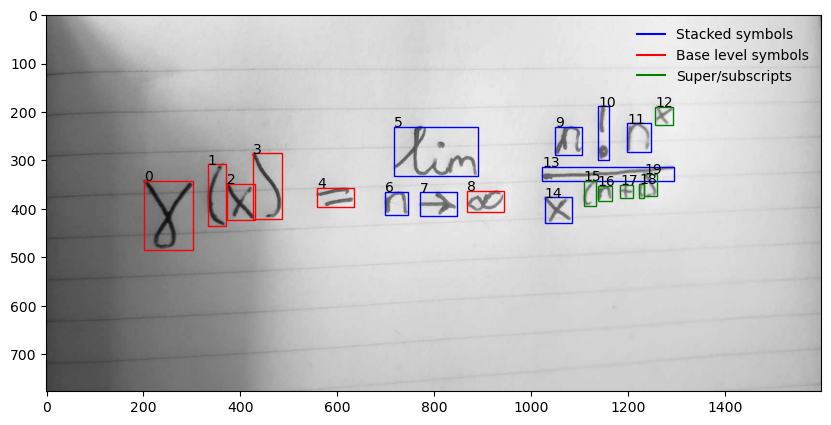

In [800]:
symbs, levels, stack, script_levels, extend, ax = resolve_symbols_on_img('../img_data/handwritten/math_martijn.jpeg')
plt.savefig('../figures/preprocessed_example.png')

## Some examples of the preprocessing pipeline

An example of a square root symbol with all the symbols inside individually identified, as well as  one of the two superscripts. 
The 'extend' list also identified how many subsequent symbols the root should extend over

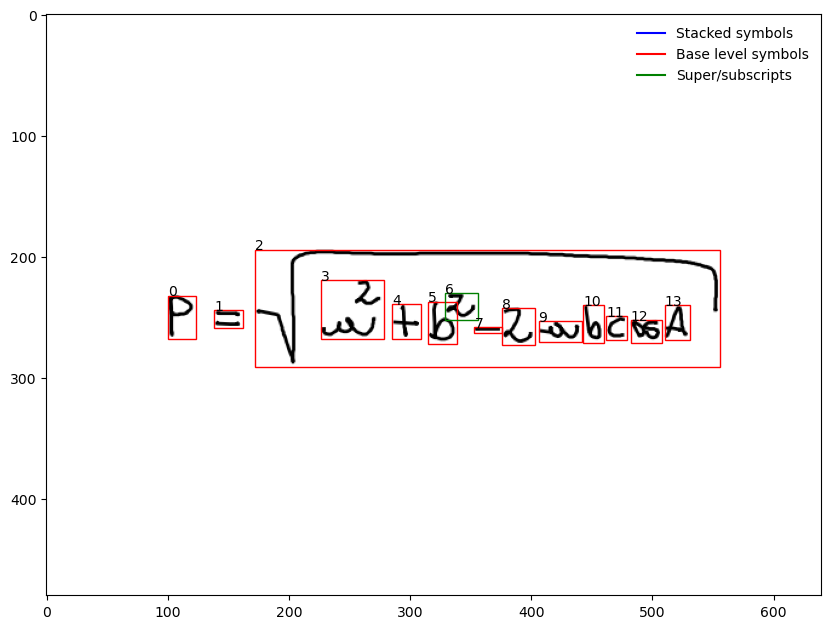

In [801]:
symbs, levels, stack, script_levels, extend, ax = resolve_symbols_on_img(full_eq_imgs[400])

In [802]:
extend

[0, 0, 11, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]

Here, an example of why the sub/superscript labeling can get tricky

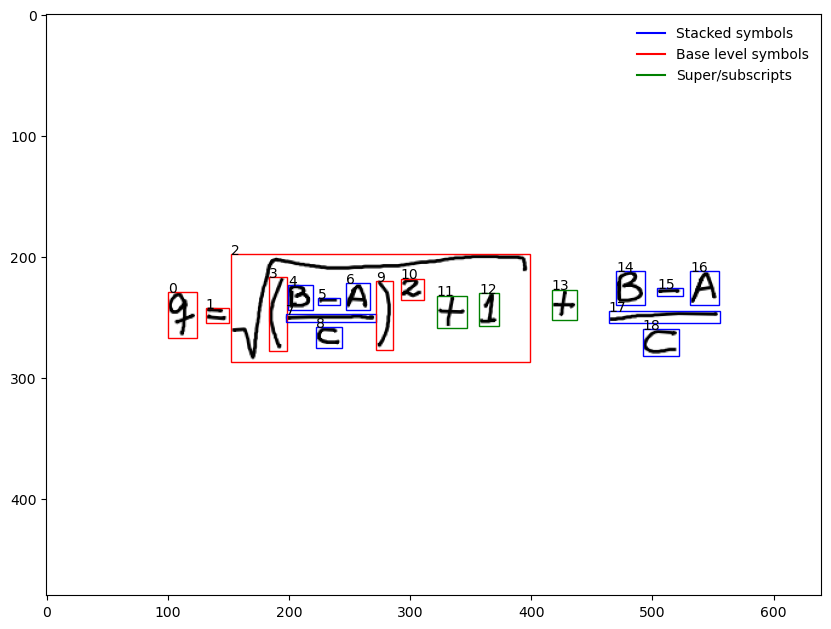

In [807]:
symbs, levels, stack, script_levels, extend, ax = resolve_symbols_on_img(full_eq_imgs[12])

Below, an example of an equation that is too complex for the pipeline to handle. When a stack is entered, the 'script level' is set back to zero - there is currently no support for stacks within a superscript, as shown here.

13
[0, 1, 2, 2, 2, 2, 2, 3, 2, 2, 0, 0, 0]


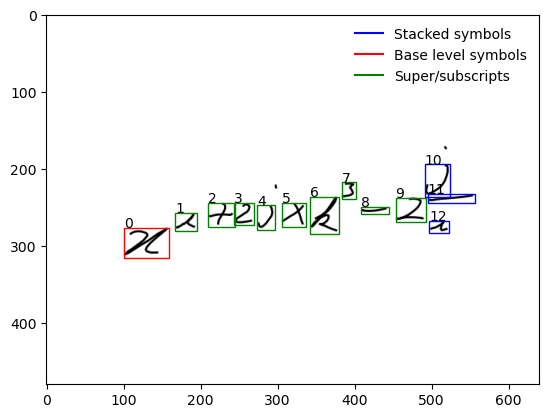

In [519]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[20])
print(script_levels)

An example of how symbols like 'tan' or 'sin' can be difficult using this method: the t, a, and n are labeled as individual symbols. To some extent this can be fixed in the postprocessing, (t, a, and n are all individual classes in the model). However, in the divisor, 'ta' is labeled as a single symbol/

13


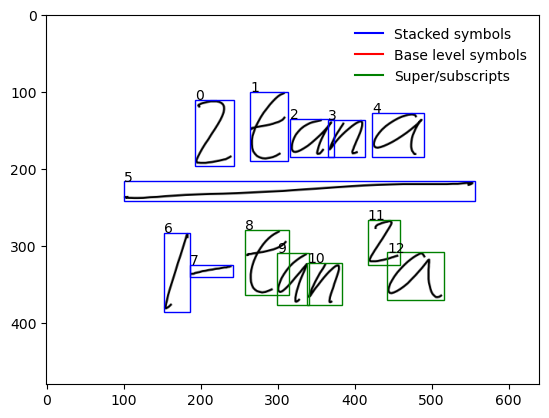

In [520]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img(full_eq_imgs[610])

Finally, lets see how well it does on one of my handwritten images

(900, 1600)


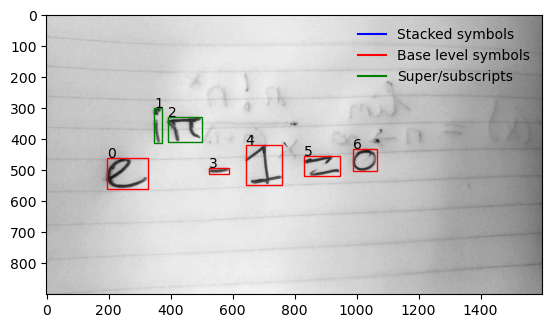

In [632]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img('../math_martijn3.jpeg')

Now let's test that it renders the individual symbols

(900, 1600)


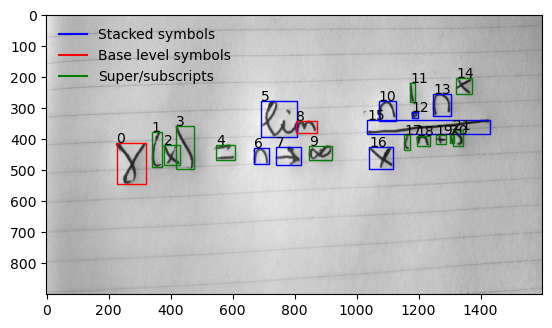

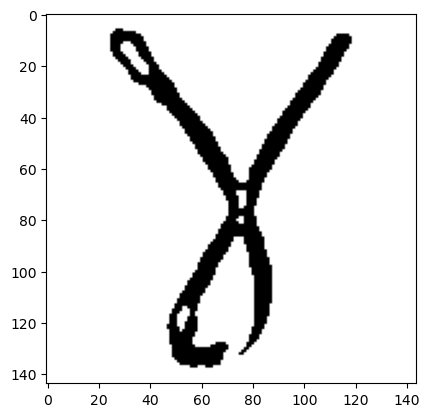

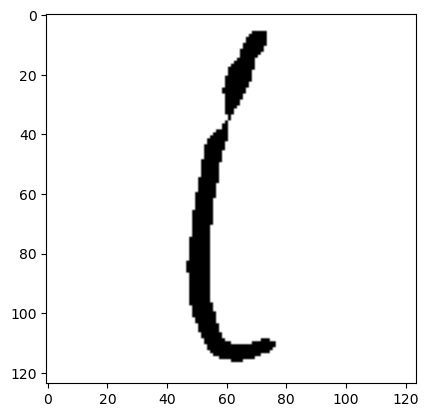

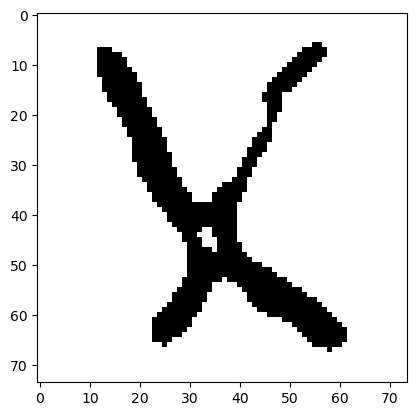

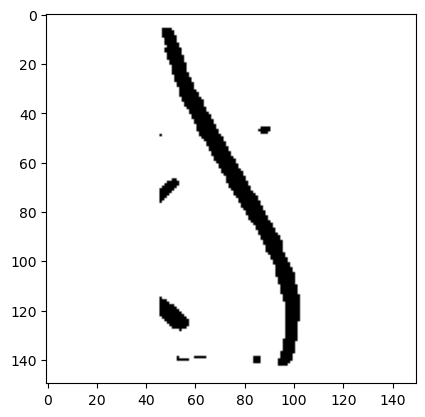

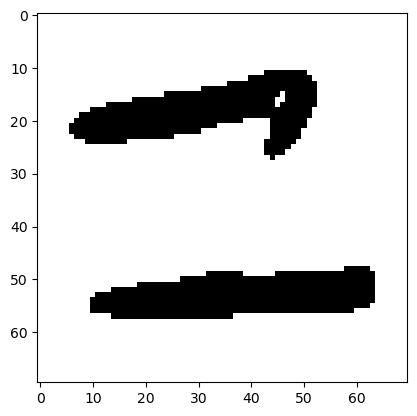

In [658]:
symbs, levels, stack, script_levels, ax = resolve_symbols_on_img('../math_martijn2.jpeg')
for symb in symbs[:5]:
    plt.figure()
    plt.imshow(symb, cmap='gray')

## That looks good!
The final function, resolve_symbols_on_img, can also be found in resolve_symbols.py, so I can call on it during the prediction pipeline